In [2]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os

In [ ]:
# Load saved models and results
bandit_difficulty = 'easy'
PLAYGROUND_DIR = f"~/logs/EI_RLDM/bandit/{bandit_difficulty}"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"
num_episodes = 400  # Adjust based on training Episodes
batch_size = 256
n_seeds = 50
test_interval = 1
save_interval = 100

grad_clip_list = [1, 5, 10]
rad_list = [1.]
lr_list = [6e-4, 8e-4, 1e-3, 1.5e-3, 2e-3]
lr_list = [round(lr, 5) for lr in lr_list]
# ablate_ii = False
ablate_ii = [True, False]
ablate_ii_list_labels = ["no", "yes"]
seeds = [i for i in range(n_seeds)]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(_, _, _, rad, ei_ratio) = para_comb[0]

lr_gc_list = list(itertools.product(lr_list, grad_clip_list))
# Initialize dictionaries to store losses
dummy_models =  {
            "rnn": {}, 
              "colei": {}, 
               "colei_ii": {}, 
              "danns": {}
              }

models = {i:  {k: {} for k in dummy_models} for i, _ in enumerate(lr_gc_list)}

n_hidden = 48
test_batch_size = 150
num_trials_per_ep = 100
test_num_trials = 100

In [ ]:
for i, (lr, gc)  in enumerate(lr_gc_list):
    for model_type in models[i].keys():
        models[i][model_type] = {k: np.zeros((n_seeds, num_episodes)) for k in ["regret", "train_loss", "num_suboptimal_pulls"]}
        models[i][model_type]["regret_trials"] = np.zeros((n_seeds, num_episodes, test_num_trials))
        
        for seed in seeds:
            
            if model_type == "colei_ii":
                ablate_ii = True
                model_type_prov = "colei"
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type_prov}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{lr}_GC{gc}_ablate_ii{ablate_ii}_adam.npz"
            elif model_type == "colei":
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{int(rad)}_lr{lr}_GC{gc}_adam.npz"
            
            else:
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.npz"
            
            if os.path.exists(results_path):
                data = np.load(results_path, allow_pickle=True)
                try:
                    models[i][model_type]["train_loss"][seed, :] = data["train_loss"][:num_episodes]
                    models[i][model_type]["regret"][seed, :] = data["regret"][:num_episodes]
                    models[i][model_type]["num_suboptimal_pulls"][seed, :] = data["num_suboptimal_pulls"][:num_episodes]
                    models[i][model_type]["regret_trials"][seed, :num_episodes, :] = np.stack(data['regret_trials'][:num_episodes])
                except Exception as e:
                    print(e, results_path)
            else:
                print(f"Warning: Missing file {results_path}")

In [32]:
def exp_avg_convolve(arr, alpha):
    kernel = (1 - alpha) ** np.arange(len(arr))
    kernel /= kernel.sum()
    return np.convolve(arr, kernel, mode='full')[:len(arr)]

In [33]:

# Compute mean and standard deviation across seeds
train_loss_mean =  {i: {model: np.mean(models[i][model]["train_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
train_loss_std = {i: {model: np.std(models[i][model]["train_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_mean = {i: {model: np.mean(np.array([exp_avg_convolve(models[i][model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_std = {i: {model: np.std(np.array([exp_avg_convolve(models[i][model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_mean2 = {i: {model: np.mean(np.trapz(models[i][model]["regret"], axis=-1), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_std2 = {i: {model: np.std(np.trapz(models[i][model]["regret"], axis=-1), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}


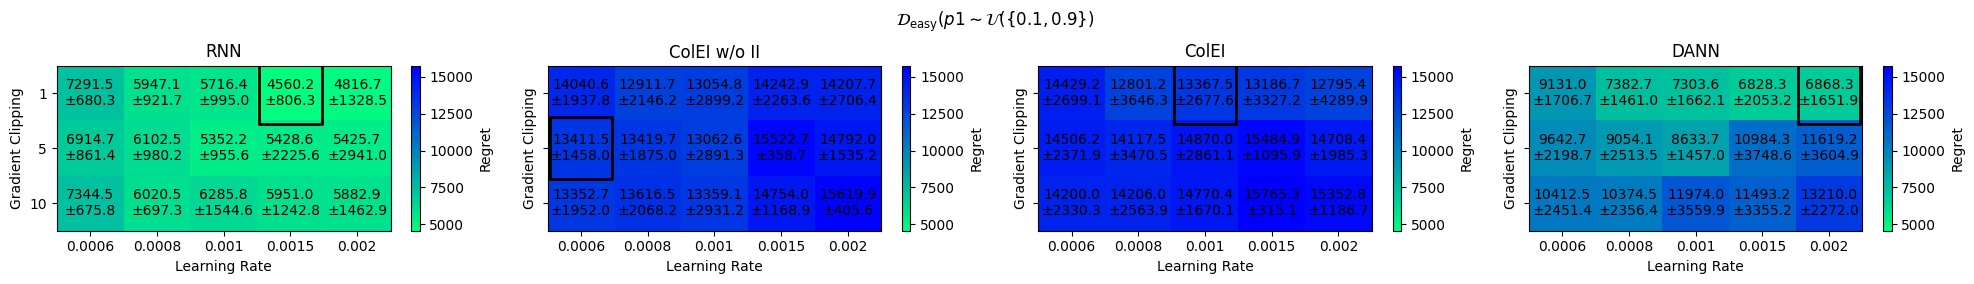

In [ ]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

dummy_labels = {"rnn": "RNN", 
          "colei_ii": "ColEI w/o II", 
          "colei": "ColEI", 
          "danns": "DANN"
          }
labels = {k: v for k,v in dummy_labels.items() if k in dummy_models.keys()}
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '-', '-','-','-','-','-']
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]

fig, axes = plt.subplots(1, 4, figsize=(20, 3), sharey='row', squeeze=False)
all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = regret_mean2
loss_std  = regret_std2

mins = []
maxs = []
heatmaps = {}
scores   = {}

for j, model_type in enumerate(labels.keys()):
    # 1) Prepare grid of lr × gc
    lr_values = sorted(set(lr for lr, gc in lr_gc_list))
    gc_values = sorted(set(gc for lr, gc in lr_gc_list))

    heatmap_matrix = np.full((len(gc_values), len(lr_values)), np.nan)
    std_matrix     = np.full_like(heatmap_matrix, np.nan)
    score_matrix   = np.full_like(heatmap_matrix, np.nan)

    # fill in
    for i, (lr, gc) in enumerate(lr_gc_list):
        row = gc_values.index(gc)
        col = lr_values.index(lr)
        mean_val = loss_mean[i][model_type]
        std_val  = loss_std[i][model_type]
        heatmap_matrix[row, col] = mean_val
        std_matrix    [row, col] = std_val
        score_matrix  [row, col] = mean_val + std_val

    mins.append(np.nanmin(heatmap_matrix))
    maxs.append(np.nanmax(heatmap_matrix))
    heatmaps[model_type] = heatmap_matrix
    scores  [model_type] = score_matrix

    ax[j].set_xticks(np.arange(len(lr_values)))
    ax[j].set_yticks(np.arange(len(gc_values)))
    ax[j].set_xticklabels(lr_values)
    ax[j].set_yticklabels(gc_values)
    ax[j].set_xlabel("Learning Rate")
    ax[j].set_ylabel("Gradient Clipping")

    # annotate
    for i in range(len(gc_values)):
        for k in range(len(lr_values)):
            val = heatmap_matrix[i, k]
            sd  = std_matrix[i, k]
            if not np.isnan(val):
                c = "white" if val < np.nanmax(heatmap_matrix) / 2 else "black"
                ax[j].text(k, i, f"{val:.1f}\n±{sd:.1f}", 
                           ha="center", va="center", color=c)

vmin = min(mins)
vmax = max(maxs)
for j, model_type in enumerate(labels.keys()):
    cax = ax[j].imshow(heatmaps[model_type], 
                       cmap=plt.cm.winter.reversed(), 
                       aspect="auto", vmin=vmin, vmax=vmax)
    best_idx = np.unravel_index(np.nanargmin(scores[model_type]), 
                                heatmaps[model_type].shape)
    cbar = plt.colorbar(cax, ax=ax[j])
    cbar.set_label("Regret")
    ax[j].set_title(labels[model_type])
    ax[j].scatter(best_idx[1], best_idx[0], marker="s", s=2000,
                  facecolors='none', edgecolors='k', linewidths=2)

fig.suptitle(r"$\mathcal{D}_{\mathrm{easy}} (p1 \sim \mathcal{U}(\{0.1,0.9\})$", y=0.93)
plt.tight_layout()
plt.show()



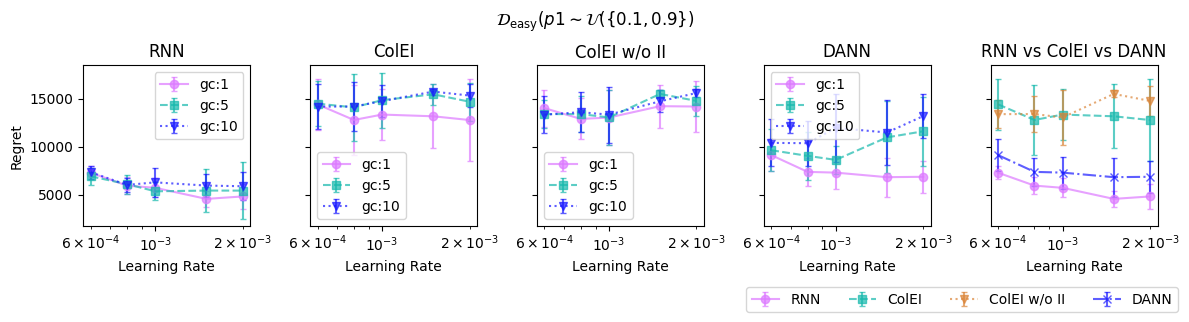

In [64]:
# Plot results
labels = {"rnn": "RNN", 
          "colei": "ColEI", 
           "colei_ii": "ColEI w/o II", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:4]) for color in COLORS]
fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True, sharex=True, squeeze=False)
colors = ["#dd7aff", "#17b9ad", "#db8539","#1a1aff" ]
colors_lrgc = ["#dd7aff", "#17b9ad", "#1a1aff" ]
all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = regret_mean2
loss_std = regret_std2
markers = ["o", "s", "v", "x"]
mins = []
maxs = []
heatmaps = {}
scores = {}
# for i, (lr, linestyle) in enumerate(zip(lr_list, linestyles)):
for j, model_type in enumerate(labels.keys()):
    # Extract unique learning rates
    # lr_values = sorted(set(lr for lr, gc in lr_gc_list))
    gc_values = sorted(set(gc for lr, gc in lr_gc_list))

    for k, gc_p in enumerate(gc_values):
        # Select the index corresponding to gradient clipping = 1
        # gc_index = gc_values.index(gc_p)

        # Extract loss values for gradient clipping = 1
        loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
        lr_values = np.array([lr for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
        std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
        # Plot the U-curve
        # ax[j].plot(lr_values, loss_values, label=f"gc:{gc_p}",  marker=markers[k], color=colors[k], linestyle=linestyles[k], alpha=0.7, zorder=3)
        ax[j].errorbar(lr_values, loss_values, yerr=std_values, label=f"gc:{gc_p}", color=colors_lrgc[k], marker=markers[k], linestyle=linestyles[k], capsize=2, alpha=0.7, zorder=3)
    ax[j].set_title(labels[model_type])
    ax[j].set_xlabel("Learning Rate")
    ax[j].set_xticks(lr_values)
    # ax[j].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*10**3}"))
    
    ax[j].legend()
    ax[j].set_xscale("log")  # Assuming learning rates are logarithmically spaced
ax[0].set_ylabel("Regret")
j = 4
# gc_p = 1
gc_ps = {"rnn": 1,
          "colei": 1 ,
           "colei_ii": 5,
          "danns": 1
          }
for k, model_type in enumerate(labels.keys()):
    # Extract unique learning rates
    # lr_values = sorted(set(lr for lr, gc in lr_gc_list))
    # gc_values = sorted(set(gc for lr, gc in lr_gc_list))

    # Select the index corresponding to gradient clipping = 1
    # gc_index = gc_values.index(gc_p)
    gc_p = gc_ps[model_type]
    # Extract loss values for gradient clipping = 1
    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    lr_values = np.array([lr for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    # Plot the U-curve
    # ax[j].plot(lr_values, loss_values, label=f"{labels[model_type]}",  marker=markers[k], color=colors[k], linestyle=linestyles[k], alpha=0.7, zorder=3)
    ax[j].errorbar(lr_values, loss_values, yerr=std_values, label=f"{labels[model_type]}", color=colors[k], marker=markers[k], capsize=2,  linestyle=linestyles[k], alpha=0.7, zorder=3)
   
    ax[j].set_xlabel("Learning Rate")
    ax[j].set_xticks(lr_values)
    # ax[j].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x}"))
    # ax[j].set_ylabel("Regret")
    # ax[j].legend()
    # ax[j].legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    
    ax[j].set_xscale("log")  # Assuming learning rates are logarithmically spaced
ax[j].set_title(f"RNN vs ColEI vs DANN")
fig.suptitle(r"$\mathcal{D}_{\mathrm{easy}} (p1 \sim \mathcal{U}(\{0.1,0.9\})$", y=0.93)
handles, labels  = ax[j].get_legend_handles_labels()
    # handles.extend(h)
    # labels.extend(l)

    # Remove duplicate labels while preserving order
    # unique_labels = []
    # unique_handles = []
    # for h, l in zip(handles, labels):
    #     if l not in unique_labels:
    #         unique_labels.append(l)
    #         unique_handles.append(h)
fig.legend(handles, labels, loc='lower left', ncol=4, bbox_to_anchor=(0.62, -0.1))

plt.tight_layout()
plt.show()


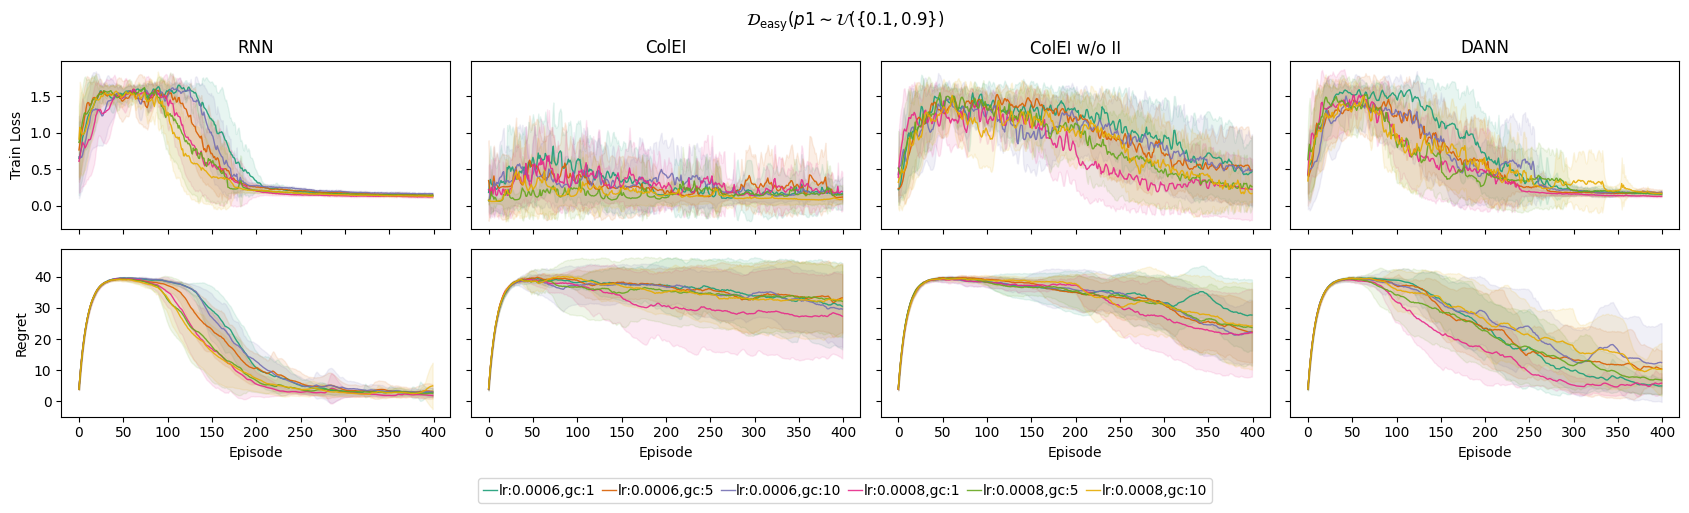

In [61]:

# Plot results
labels = {"rnn": "RNN", 
          "colei": "ColEI", 
           "colei_ii": "ColEI w/o II", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Dark2').colors
linestyles = ['-', '-', '-','-','-','-']#,'--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:4]) for color in COLORS]
# colors = [plt.cm.winter(v) for v in np.linspace(0., 1., len(lr_gc_list))[::-1]]
fig, axes = plt.subplots(2, 4, figsize=(17, 5), sharey='row', sharex=True)

# Training Loss

### Helper Function to Plot with Dynamic Y-Limits ###
def plot_metric(ax, loss_mean, loss_std, title, y_label, plot_x_label=True):
    all_loss_values = {model_type: [] for model_type in labels.keys()}

    for i, ((lr, gc), linestyle) in enumerate(zip(lr_gc_list, linestyles)):
        for j, model_type in enumerate(labels.keys()):
            loss_values = loss_mean[i][model_type]
            std_values = loss_std[i][model_type]

            # Collect values for dynamic y-limit computation
            all_loss_values[model_type].extend(loss_values - std_values)
            all_loss_values[model_type].extend(loss_values + std_values)
            
            # Plot mean and std range
            ax[j].plot(loss_values, label=f"lr:{lr},gc:{gc}", color=colors[i], linestyle=linestyles[i],lw=1, alpha=0.9, zorder=2)
            ax[j].fill_between(range(num_episodes), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.1)

    for j, model_type in enumerate(labels.keys()):
        if plot_x_label:
            ax[j].set_xlabel("Episode")
    ax[0].set_ylabel(f"{y_label}")
        # ax[j].legend()
       

        # # Apply dynamic y-limits (ignore NaN, remove extreme outliers)
        # all_loss_values[model_type] = np.nan_to_num(all_loss_values[model_type], nan=0)
        # y_min, y_max = np.percentile(all_loss_values[model_type], [1, 99])
        # ax[j].set_ylim(y_min, y_max)

### **Train Loss Plot (Row 1, Col 0)**
for j, model_type in enumerate(labels.keys()):
    axes[0, j].set_title(f"{labels[model_type]}")

plot_metric(axes[0, :], train_loss_mean, train_loss_std, "Train Loss", "Train Loss", plot_x_label=False)

### **Test Loss Plot (Row 1, Col 1)**
plot_metric(axes[1, :], regret_mean, regret_std, "Regret", "Regret")


handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels,
            loc='lower center',
            ncol=len(unique_labels),
            handlelength=1, 
            handletextpad=0.1, 
            # ncol=4, 
            columnspacing=0.5,
            bbox_to_anchor=(0.5, -0.05))
fig.suptitle(r"$\mathcal{D}_{\mathrm{easy}} (p1 \sim \mathcal{U}(\{0.1,0.9\})$", y=0.95)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()